In [1]:
# Python Version 3.8.10
# Importing libraries 
import numpy as np
import PIL 
from PIL import Image
import random
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader , Dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import PIL.ImageOps as ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Creating helper functions to visualize images and losses
def image_show(img , text = None ,save = False):
    ''' This Function plots the image.'''
    npimg = img.numpy()
    plt.axis("off")
    
    if text is not None: #if there is text to insert
        plt.text(75,8 , text , style= "italic" , fontweight = "bold" , bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg , (1,2,0)))
    plt.show()

def plot_loss(iteration , loss):
    plt.plot(iteration , loss)
    plt.grid(True)
    plt.xlabel("ITERATIONS")
    plt.ylabel("LOSS")
    plt.show()

In [3]:
class CustomDataset(Dataset):
    
    def __init__(self,image_folders,transform=None,should_invert=True):
        self.image_folders = image_folders    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.image_folders.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.image_folders.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.image_folders.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.image_folders.imgs)

In [5]:

#Defining the paths for training and testing data
training_dir = "/home/parth/Documents/ImageSimilarity_Code/training_copy/"
testing_dir = "/home/parth/Documents/ImageSimilarity_Code/testing_copy/"

folder_dataset = dset.ImageFolder(root = training_dir)

In [8]:
transform = transforms.Compose([transforms.Resize((100,100)) , transforms.ToTensor()])

dataset = CustomDataset(image_folders = folder_dataset , transform = transform , should_invert = False)
v_loader = DataLoader(dataset , shuffle = True ,batch_size = 8)
print(len(v_loader))

20


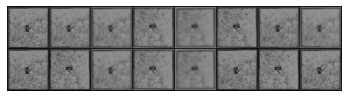

In [9]:
#Visualizing some of the data

v_loader = DataLoader(dataset , shuffle = True ,batch_size = 8)
data_iter = iter(v_loader)
ex_batch = next(data_iter)
cc = torch.cat((ex_batch[0] , ex_batch[1]) , 0)
image_show(vutils.make_grid(cc))

In [10]:
#Declaring variable to check whether gpu is available or not
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Using GPU")
else:
    print("Using CPU")

Using CPU


In [12]:
#Describing the architecture of the convolutional net

class Siamese_net(nn.Module):
    
    def __init__(self):
        super(Siamese_net , self).__init__()
        
        self.conv_layers = nn.Sequential(
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(1,4 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(4),
                                
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(4,8 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(8),
        
                                nn.ReplicationPad2d(1),
                                nn.Conv2d(8,8 , kernel_size = 3),
                                nn.ReLU(inplace = True),
                                nn.BatchNorm2d(8))
        
        self.fully_connect = nn.Sequential(nn.Linear(8*100*100 , 500),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(500,500),
                                           nn.ReLU(inplace = True),
                                           nn.Linear(500 , 5))
    
    def forward_once(self , x):
        output = self.conv_layers(x)
        output = output.view(output.size()[0], -1)
        output = self.fully_connect(output)
        return output
    
    def forward(self , inp1 , inp2):
        
        op1 = self.forward_once(inp1)
        op2 = self.forward_once(inp2)
        
        return op1 , op2

In [13]:
#Defining the loss

class Contrastive_loss(torch.nn.Module):
    
    '''Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf'''
    def __init__(self, margin=2.0):
        super(Contrastive_loss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [14]:
batch_size = 64 
num_epochs = 150

#Defning the data loader

train_loader = DataLoader(dataset , batch_size = batch_size , shuffle = True)

In [15]:
net = Siamese_net()
if use_cuda:
    net = net.cuda()
    print(net)
criterion = Contrastive_loss()
optimizer = optim.Adam(net.parameters() , lr = 0.0005)

In [16]:
iteration_num = 0
counter = []
loss_history = []

In [17]:
#Training time

for epoch in range(num_epochs):
    
    for i , data in enumerate(train_loader , 0):
        
        img0 , img1 , label = data
        if use_cuda:
            img0 , img1 , label = img0.cuda() , img1.cuda() , label.cuda()
        optimizer.zero_grad()
        op1 , op2 = net(img0 , img1)
        loss = criterion(op1 , op2 , label)
        loss.backward()
        optimizer.step()
        
        if i%10 == 0:
            print("Epoch : {} || Contrastive Loss : {}".format(epoch , loss.item()))
            iteration_num += 10
            counter.append(iteration_num)

Epoch : 0 || Contrastive Loss : 1.7842657566070557
Epoch : 1 || Contrastive Loss : 0.16745494306087494
Epoch : 2 || Contrastive Loss : 0.03617248684167862
Epoch : 3 || Contrastive Loss : 0.009820460341870785
Epoch : 4 || Contrastive Loss : 0.029962651431560516
Epoch : 5 || Contrastive Loss : 0.20449230074882507
Epoch : 6 || Contrastive Loss : 0.0034982480574399233
Epoch : 7 || Contrastive Loss : 0.011465017683804035
Epoch : 8 || Contrastive Loss : 0.22637328505516052
Epoch : 9 || Contrastive Loss : 0.5208624005317688
Epoch : 10 || Contrastive Loss : 0.0017241244204342365
Epoch : 11 || Contrastive Loss : 0.021559948101639748
Epoch : 12 || Contrastive Loss : 0.014576311223208904
Epoch : 13 || Contrastive Loss : 0.015553074888885021
Epoch : 14 || Contrastive Loss : 0.00020003128156531602
Epoch : 15 || Contrastive Loss : 0.031713299453258514
Epoch : 16 || Contrastive Loss : 0.007090149447321892
Epoch : 17 || Contrastive Loss : 0.003380740527063608
Epoch : 18 || Contrastive Loss : 0.0014394

In [20]:
# plot_loss(counter , loss_history)


In [21]:

#Time for testing
test_data_folder = dset.ImageFolder(root = testing_dir)

transform = transforms.Compose([transforms.Resize((100,100)) , transforms.ToTensor()])

test_dataset = CustomDataset(test_data_folder , transform  = transform, should_invert = False)

test_loader = DataLoader(test_dataset , batch_size = 1 , shuffle  = True)